# UNSW Workshop on Sentiment Analysis

May, 2022 by Christian Hotz-Behofsits

Topics:

 - Google Colab (e.g., open file from GitHub, change Runtime)
 - Online/offline processing
 - Sentiment Analysis (Classification/Positivity)
 - Workflow: (1) always save intermediate results (2) use code versioning (e.g., GitHub) and (3) comment your own code

## Download files

The following code creates a folder named _data_ and downloads our already loaded tweets.

In [ ]:
%%bash
mkdir data
wget "https://dl.dropboxusercontent.com/s/js3wdmxkjbqku56/nike_tweets_rnd.jsonl.gz?dl=0" -O ./data/nike_tweets_rnd.jsonl.gz

## Filter Tweets

Online algorithm (= process tweets chunkwise) to filter Tweets. Such an procedure can be scaled to medium-sized data sets spanning billions of rows.

In [4]:
import json
import gzip

with gzip.open('./data/nike_tweets_rnd_filtered.jsonl.gz', 'wt') as of:
    with gzip.open('./data/nike_tweets_rnd.jsonl.gz', 'rt') as f:
        for l in f:
            dct = json.loads(l)

            # we will filter out all other languages except en
            if not dct['lang'] == 'en':
                continue

            # avoid scheduled tweets
            if dct['source'] not in ["Twitter Web Client", "Twitter for iPhone", "Twitter for Android"]:
                continue

            # also skip retweets ...
            if dct['text'][:3] == 'RT ':
                continue

            # select only relevant 'columns'
            outp = {
              'created_at': dct['created_at'],
              'text': dct['text']
            }

            # write out to jsonlines file
            of.write(json.dumps(outp) + '\n')

## Volume

First model-free analysis of the data at hand. Vizualizes the daily number of Tweets.

In [5]:
import pandas as pd 

df = pd.read_json(
    # compression is automatically detected
    # but we have to state that the format is 
    # line-wise json
    './data/nike_tweets_rnd_filtered.jsonl.gz', lines = True
    
    # setting the date as column
    # saves us some time later, because it
    # makes it easier to group by this column
).set_index('created_at')

df.head(3)

,text
created_at,
2018-08-03 23:57:12+00:00,Nike boyzzzzzzzzzzzz
2018-08-03 23:54:51+00:00,Guess Drake back on team Nike and I’m all for ...
2018-08-03 23:49:08+00:00,My mom said I have an addiction to adidas and ...


<AxesSubplot:xlabel='created_at'>

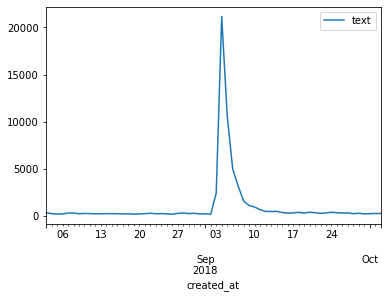

In [6]:
# the created_at column states the time
# when the specific tweet was posted.
# The grouper can be used to aggreagte it
# on daily (D) or weekly (W) level
df.groupby(pd.Grouper(freq='D')).count().plot()

## Sentiment analysis

In [ ]:
# hugging face provides state of the art deep learning models
# the package can be installed as follows
!pip install transformers

In [8]:
from transformers import pipeline

clf = pipeline(
    # we want to carry out a sentiment-analysis task
    'sentiment-analysis', 

    # sentiment model used for inference
    # this is the default
    model = 'distilbert-base-uncased-finetuned-sst-2-english',

    # device=0: use GPU (check your runtime!);
    # device=-1: use CPU (slower, but always available) 
    device=0, 
    
    # defaults to return only the "most-likely" label
    return_all_scores=True
)

In [9]:
#it's a lie... but
clf('I hate pizza!')

[[{'label': 'NEGATIVE', 'score': 0.9995840191841125},
  {'label': 'POSITIVE', 'score': 0.0004159875970799476}]]

In [10]:
pos_score = lambda txt: clf(txt)[0][1]['score']
pos_score('i love you')

0.9998656511306763

In [11]:
pos_score('i hate you')

0.0008870700839906931

In [ ]:
# the following two lines provide us a convenient way to visualize 
# the progress when applying a method on a lot of data ...
from tqdm.auto import tqdm
tqdm.pandas()

df['pos_score'] = df.text.progress_apply(pos_score)

In [ ]:
df.to_json('nike_tweets_rnd_sentiment.jsonl.gz', lines=True, orient='records')

# Analysing the data

In [ ]:
import pandas as pd

df = pd.read_json(
    './data/nike_tweets_rnd_sentiment.jsonl.gz', lines=True
).set_index('created_at')

df.head(5)

In [ ]:
df.groupby(pd.Grouper(freq='D')).pos_score.median().plot()